# Imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the dataset

In [1]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2021-04-03 20:42:06--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 172.217.15.78, 2607:f8b0:4004:810::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hq73afo1oi4n9bn6r8guoqro5irfgq88/1617482475000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-04-03 20:42:06--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hq73afo1oi4n9bn6r8guoqro5irfgq88/1617482475000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 172.217.12.225, 2607:f8b0:4004:807::2001
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|172.217.12.225|:4

In [3]:
dataset = pd.read_csv('/tmp/sentiment.csv')

# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Create a subword dataset

In [4]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, 
                                                                      vocab_size, 
                                                                      max_subword_length=5)
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


# Replace sentence data with encoded subwords

In [6]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [8]:
# Check if the encoding went well
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [9]:
max_length = 50
trunc_type='post'
padding_type='post'

sequences_padded = pad_sequences(sentences, 
                                 maxlen=max_length, 
                                 padding=padding_type, 
                                 truncating=trunc_type)

In [10]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [11]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [13]:
# Create the model
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16,091
Trainable params: 16,091
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 30

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(training_sequences,
                    training_labels_final,
                    epochs = num_epochs,
                    validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 4s 12ms/step - loss: 0.6932 - accuracy: 0.4777 - val_loss: 0.6945 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5333 - val_loss: 0.6937 - val_accuracy: 0.4361
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5667 - val_loss: 0.6919 - val_accuracy: 0.5113
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6606 - val_loss: 0.6882 - val_accuracy: 0.6090
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.7250 - val_loss: 0.6799 - val_accuracy: 0.7293
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.7709 - val_loss: 0.6701 - val_accuracy: 0.6867
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.7927 - val_loss: 0.6471 - val_accuracy: 0.7293
Epoch 8/30
50/50 [=

In [15]:
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

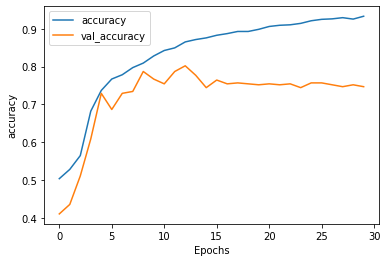

In [16]:
plot_graphs(history,'accuracy')

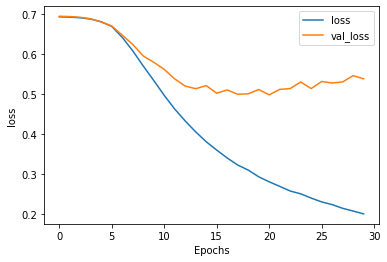

In [17]:
plot_graphs(history,'loss')

In [18]:
def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

# Text on some fake reviews

In [19]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.8186372]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.10869813]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.25565493]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.08108661]


[  1 109 228 540 237 635 24

In [20]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

In [21]:
def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

In [22]:
def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

# Add a bidirectional LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 32s 22ms/step - loss: 0.6913 - accuracy: 0.5149 - val_loss: 0.6972 - val_accuracy: 0.4311
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6561 - accuracy: 0.6000 - val_lo

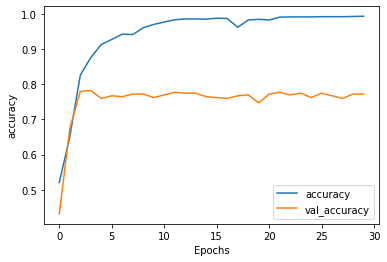

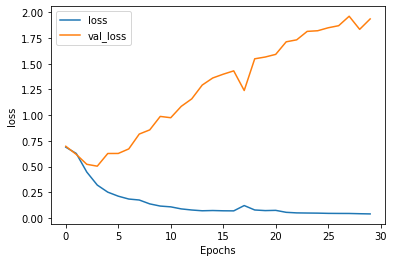

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9999082]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01775151]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.02508633]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.01957637]


[  1 109 228 540 237 635 24

In [24]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_bidi_lstm,fake_reviews)

# Use a multiple bidirectional layers

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 6s 37ms/step - loss: 0.6924 - accuracy: 0.5355 - val_loss: 0.699

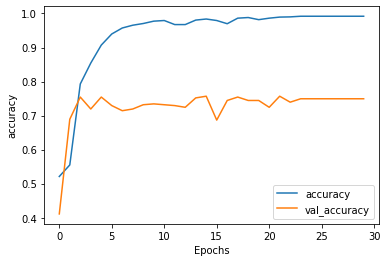

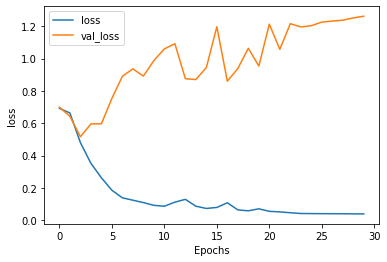

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9995795]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01843761]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.931723]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.01650926]


[  1 109 228 540 237 635 241 

In [25]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Lets try it on some reviews

In [26]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [27]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.85540277]


dreadful
[0.28800008]


stay away
[0.5595506]


everything was hot exactly as I wanted
[0.6252265]


everything was not exactly as I wanted
[0.38825086]


they gave us free chocolate cake
[0.6184559]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02864846]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.5557066]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7652648]


that place does not have quality meals and it isn't a good place to go for dinner
[0.7608553]




In [28]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.9997712]


dreadful
[0.02107154]


stay away
[0.6031597]


everything was hot exactly as I wanted
[0.41754243]


everything was not exactly as I wanted
[0.01806236]


they gave us free chocolate cake
[0.9812383]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.28498024]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.10624235]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99431264]


that place does not have quality meals and it isn't a good place to go for dinner
[0.01802325]




In [29]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.9997712]


dreadful
[0.02107154]


stay away
[0.6031597]


everything was hot exactly as I wanted
[0.41754243]


everything was not exactly as I wanted
[0.01806236]


they gave us free chocolate cake
[0.9812383]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.28498024]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.10624235]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99431264]


that place does not have quality meals and it isn't a good place to go for dinner
[0.01802325]




In [30]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
lovely
[0.9995189]


dreadful
[0.01065149]


stay away
[0.01000214]


everything was hot exactly as I wanted
[0.98021495]


everything was not exactly as I wanted
[0.01282485]


they gave us free chocolate cake
[0.9995115]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.0122883]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.0149143]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.98916817]


that place does not have quality meals and it isn't a good place to go for dinner
[0.018242]


